Stock Price prediction Using LSTM.

Pandas datareader : https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-tiingo

Tiingo : Tiingo is a tracing platform that provides a data api with historical end-of-day prices on equities, mutual funds and ETFs. 
    Free registration is required to get an API key. 
    Free accounts are rate limited and can access a limited number of symbols



API token: 0f2d66254ed2884134ff661f2eecaf9b6b74ee98

In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np


In [2]:
key = "0f2d66254ed2884134ff661f2eecaf9b6b74ee98"

In [3]:
# df = pdr.get_data_tiingo('AAPL', api_key = key)
# 50 api call allowed per day

c:\Users\Rahul raaghav A\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [4]:
# df.to_csv('AAPL.csv')

In [5]:
df = pd.read_csv('AAPL.csv')

In [28]:
# df.head()
df.head()
# Recent data before 3 days is available

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-06-14 00:00:00+00:00,145.16,147.5000,143.84,147.50,31224203,34.348279,34.901978,34.035936,34.901978,124896812,0.0,1.0
1,AAPL,2017-06-15 00:00:00+00:00,144.29,144.4798,142.21,143.32,31348832,34.142416,34.187328,33.650239,33.912892,125395328,0.0,1.0
2,AAPL,2017-06-16 00:00:00+00:00,142.27,144.5000,142.20,143.78,49180748,33.664437,34.192107,33.647873,34.021738,196722992,0.0,1.0
3,AAPL,2017-06-19 00:00:00+00:00,146.34,146.7400,143.66,143.66,31449132,34.627495,34.722144,33.993344,33.993344,125796528,0.0,1.0
4,AAPL,2017-06-20 00:00:00+00:00,145.01,146.8700,144.94,146.87,24572170,34.312785,34.752905,34.296222,34.752905,98288680,0.0,1.0


In [7]:
# Analysis is performed only on closing price for now
df1 = df.reset_index()['close']

df2 = df[['close', 'date']]
# df1.head()
# df2.head()

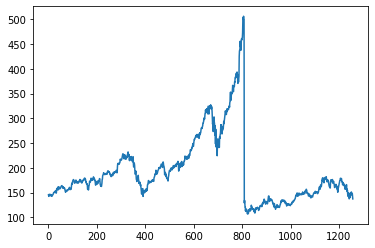

In [8]:
# Let us plot the closing price data to observe the general trend
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
# Define an LSTM model
# LSTM's are sensitive to the scale of the data so scale them properly
# Use sklearn library for MinMax scaling

from sklearn.preprocessing import MinMaxScaler

# define a scaler object that scale the data to the given range
scaler = MinMaxScaler(feature_range=(0,1))
# Use this scaler object to scale the df1 
# We need to convert df1 to a numpy array

np_array = np.array(df1)
# np_array.shape

# Reshape it because scaler.fit_transform expects a 2d array

np_array = np_array.reshape(-1,1)
# np_array.shape

df1 = scaler.fit_transform(np_array)
df1.shape

(1258, 1)

In [10]:
print(len(df1))
# We have data for 1258 days

1258


In [11]:
# Split the data into train and test split
# while working with time series data we are not supposed to shuffle the data, obviously.
# Series should be maintained in order to the date

train_size = int(len(df1)*0.65)
test_size = len(df1) - train_size

train_data = df1[:train_size,:]
test_data  = df1[train_size:len(df1),:1] 

print(train_data.shape)
print(test_data.shape)


(817, 1)
(441, 1)


In [12]:
# We need to define a function that gives the data in the format that we need
# time step is the number of previous data point that we will use as an input to our LSTM model
# to predict the next data output
# if time step = 100 then tn-100 .... tn-1 is used to get tn

def create_dataset(dataset, time_step = 1):
    dataX,dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [13]:
# format the data in the required order using the function

time_step = 100
# Training data
X_train, Y_train = create_dataset(train_data,time_step)
# Testing data
X_test, Y_test = create_dataset(test_data,time_step)

# print(X_train.shape)
# Each row has data starting from that index to index + time_step

In [14]:
# For giving the input to the LSTM we will give reshape the data to have one more dimension

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# print(X_test.shape)
# print(X_train.shape)

# print(X_train)

In [15]:
# Creating the LSTM model using Keras

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [16]:
model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape = (100,1)))

model.add(LSTM(50,return_sequences=True))

model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Now that model has been built, start the training
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100, batch_size=32)

Epoch 1/100
23/23 [==============================] - 2s 96ms/step - loss: 0.0012 - val_loss: 1.3703e-04
Epoch 2/100
23/23 [==============================] - 2s 102ms/step - loss: 0.0020 - val_loss: 1.3586e-04
Epoch 3/100
23/23 [==============================] - 2s 96ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 4/100
23/23 [==============================] - 2s 95ms/step - loss: 0.0020 - val_loss: 2.1293e-04
Epoch 5/100
23/23 [==============================] - 2s 106ms/step - loss: 0.0017 - val_loss: 1.2777e-04
Epoch 6/100
23/23 [==============================] - 2s 104ms/step - loss: 0.0013 - val_loss: 3.9862e-04
Epoch 7/100
23/23 [==============================] - 3s 111ms/step - loss: 0.0013 - val_loss: 1.4120e-04
Epoch 8/100
23/23 [==============================] - 3s 120ms/step - loss: 0.0012 - val_loss: 1.1256e-04
Epoch 9/100
23/23 [==============================] - 3s 112ms/step - loss: 0.0012 - val_loss: 2.8208e-04
Epoch 10/100
23/23 [==============================] - 3s 121ms

In [22]:
model.save('AAPL_pred.h5')

In [23]:
# Now that training is done validate with both training and test data

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Output predict by the model is in scaled form
# So we need to transform it back

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [25]:
# Let's Calculate the mean squared error of the predictions
import math
from sklearn.metrics import mean_squared_error

# validation on Training set
# mae = mean_squared_error(Y_train,train_predict)
# print(f'Accuracy is : {math.sqrt(mae)}')

# validation on Test set
mae = mean_squared_error(Y_test,test_predict)
print(f'Accuracy is : {math.sqrt(mae)}')

Accuracy is : 147.89494612583144


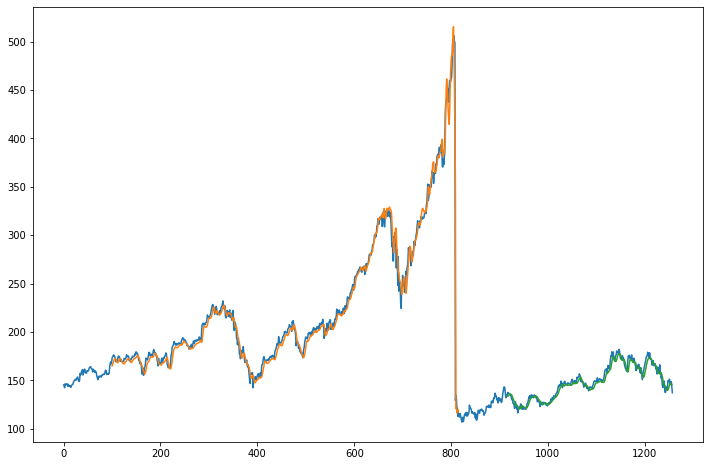

In [27]:
# Now let's compare the predictions by plotting

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(12,8)) 
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [40]:
# Now let us predict the output for the future 30 days
# For this we need past 100 days of data

print(len(test_data))

x_input = test_data[441-100:].reshape(1,-1)
print(x_input.shape)
print(type(x_input))

441
(1, 100)
<class 'numpy.ndarray'>


In [50]:
# Create a list with the previous 100 data points
# Convert numpy array to python list
# So that we can use the extend() functionality to add data to the list as we predict
Input = list(x_input)
# print(len(Input))
Input = Input[0].tolist()
# print(Input)
print(len(Input))

100


In [53]:
from numpy import array

lst_output=[]
n_steps=100
i=0

while(i<30):
    print('->',end = "")
    if(len(Input)>100):
        x_input = np.array(Input[1:]) # The prev 100 data points are collected
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        Input.extend(yhat[0].tolist())
        Input = Input[1:] # Only the last 100 data point is retained and used for predicting next value
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        
        Input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->

In [56]:
# lst_output conains the predictions for the next 30 days
print(len(lst_output))

30


In [61]:
# Let us plot the predictions of the next 30 days.
days = np.arange(1,101)
# print(days)
pred_days = np.arange(101,131)
print(len(pred_days))

30


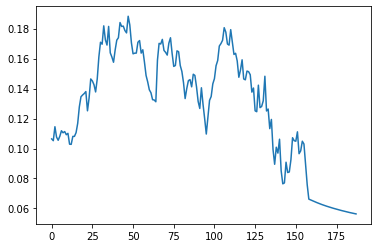

In [63]:
# Add all the previous data to the newly predicted data for visulalization

all_data = df1.tolist()
all_data.extend(lst_output)

plt.plot(all_data[1100:])


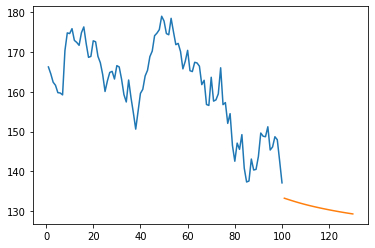

In [66]:
# New plot for differentiating between predicted data and old data

plt.plot(days,scaler.inverse_transform(df1[1158:]))
plt.plot(pred_days,scaler.inverse_transform(lst_output))


In [ ]:
# The LSTM model predicts a downward trending price for the stock. This correlates with the overal trend of the Stock.
# But the prediction is smoothed out and is unable to capture the micro movements of the stock.
# Probably adding more features to the model than just closing price might improve the performance.
# Features that can be used : Volume, Opening price, index values, etc.

# Rahul raaghav A